# Simple text mining teknikker

Indtil videre har vi arbejdet med enkelte tekststykker, men hvordan oversætter vi disse teknikker til større samlinger? (corpus)

En samling af dokumenter eller tekster, der bruges til at undersøge et bestemt tema eller en bestemt problemstilling, kaldes et *corpus* (et term fra lingvistik).

Der er forskellige dataformater til at arbejde med corpora kvantitativt. Et udbredt format er et "document-term-matrix" (dtm) eller et "term-document-matrix" (tdm). Et document-term-matrix er en tabel, hvor dokumenterne/teksterne udgør rækkerne og tokens udgør kolonner. Hver celle er så en tælling af et token inden for hvert dokument. Et "term-document-matrix" er det samme, men hvor tokens udgør rækker og dokumenter udgør kolonner. 

Et "document-term-matrix" er nyttigt og nødvendigt til forskellige modeller, men formatet egner sig ikke særlig godt til mere simple, eksplorative text mining teknikker. Dette fordi at det er vanskeligt at bevare anden information, som man har i teksterne, i det format (fx forfatter af teksten, udgivelsestidspunkt eller andet).

## Tidy text data

Et alternativt format er et såkaldt "tidy text" format. I dette format betragtes hver optræden af et token som en observation. I dette format foregår der ikke nogen form for opsummering eller optælling i selve dataformatet. I stedet splittes tokens i tekster ud i rækker, så man for hver optræden af et token kan kombinere det med de øvrige oplysninger, som man har i data.

Tilgangen er mindre udbredt i Python, men ses ofte brugt i R (se fx [Silge, J og D Robinson: "Text Mining with R: A Tidy Approach"](https://www.tidytextmining.com/)).

**Fordele:**
- Fastholder dokumenttilhør og andre relevante oplysninger
- Gør det nemt at arbejde med
- Vi kan bruge pandas metoder til nemt at lave opsummeringer og visualiseringer
    
**Ulemper:**
- Data fylder hurtigt meget
- Kan have effekt på beregningstiden
- Ikke kompatibelt med mange modeller (data skal måske konverteres igen for at passe med model)

In [35]:
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize':(20,12)})

tweetdata_url = "https://raw.githubusercontent.com/CALDISS-AAU/course_ndms-I/master/datasets/poltweets_sample.csv"
tweets_df = pd.read_csv(tweetdata_url)

## Fra text corpora til tidy text i Python

Python (og pandas) har flere funktioner, der gør det nemt at anvende funktioner på alle værdier i en kolonne. Twitterdata er lige nu læst ind som en dataframe, hvor selve tweetet fremgår af kolonnen `full_text`:

In [36]:
tweets_df['full_text'].head()

0    Er på vej i miljøministeriet for at foreslå at...
1    @nielscallesoe @helenehagel @alternativet_ Det...
2    Vi står sammen, smiler Løkke på KL-topmøde og ...
3             @AnnaBylov @EU_Spring @rasmusnordqvist 💚
4    Der er ikke noget alternativ til at Alternativ...
Name: full_text, dtype: object

Det anbefales altid, at lave en tilpasset tokenizer, men det er muligt blot at bruge tokenizeren fra spaCy, som den er.

Da hver celle i kolonnen `full_text` består af et enkelt tekststykke (et tweet), kan en tokenizer-funktion bruges på hvilken som helst celle i kolonnen:

In [53]:
from spacy.lang.da import Danish
nlp = Danish() # Indlæser "tom" sprogmodel
tokenizer = nlp.tokenizer # henter tokenizer

def tokenizer_simple(text):
    stop_words = list(nlp.Defaults.stop_words)
    
    doc = tokenizer(text)
    
    tokens = []
    
    for word in doc:
        if len(word.text) < 3:
            continue
        if word.text not in stop_words:
            tokens.append(word.text)
    
    return(tokens)

In [54]:
tokens = tokenizer_simple(tweets_df.loc[102, 'full_text'])

print(tweets_df.loc[102, 'full_text'])
print("\n")
print(tokens)

- Hvordan sikrer vi at forebyggelse og behandling af cannabismisbrug blandt unge bliver styrket gennem legalisering af cannabis i Danmark? 
Det var omdrejningspunktet i en to timers debat med dem, der har “hands on” på området, nemlig misbrugsbehandlerne. 💚@alternativet_  #dkpol https://t.co/DnxKEGk9Ab


['Hvordan', 'sikrer', 'forebyggelse', 'behandling', 'cannabismisbrug', 'unge', 'styrket', 'legalisering', 'cannabis', 'Danmark', 'Det', 'omdrejningspunktet', 'timers', 'debat', 'hands', 'området', 'misbrugsbehandlerne', '@alternativet', 'dkpol', 'https://t.co/DnxKEGk9Ab']


**Brug af `.apply()` på pandas series**

Funktionen virker ikke på hele kolonnen, da funktionen er lavet til at tage et enkelt tekststykke som input (og ikke en pandas series):

In [55]:
tokenizer_simple(tweets_df['full_text'])

TypeError: Argument 'string' has incorrect type (expected str, got Series)

Man kan dog nemt få Pandas til at køre den samme funktion over hver celle i en kolonne med metoden `.apply()` (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html?highlight=apply#pandas.Series.apply).

`.apply()` anvendes på en pandas series og tager en funktion som input. Metoden kan tænkes lig et for loop, hvor funktionen, som man angiver som input, anvendes på hver celle i kolonnen.

Herunder dannes en ny kolonne (`tokens`), som dannes ved at anvende funktionen på kolonnen `full_text` med `.apply()` (OBS: Dette kan tage noget tid):

In [56]:
tweets_df['tokens'] = tweets_df['full_text'].apply(tokenizer_simple)

**Fra tokens som lister til tokens som rækker**

Funktionen `tokenizer_spacy` returnerer en liste af tokens. Kolonnen `tokens` indeholder derfor listen af tokens for hver tekst:

In [57]:
tweets_df['tokens'].head()

0    [vej, miljøministeriet, foreslå, laver, biodiv...
1    [@nielscallesoe, @helenehagel, @alternativet, ...
2    [står, smiler, Løkke, KL-topmøde, tager, 2,4, ...
3           [@AnnaBylov, @EU_Spring, @rasmusnordqvist]
4    [Der, alternativ, Alternativet, går, forrest, ...
Name: tokens, dtype: object

Data er derfor ikke tidy, da vi ikke har et ord per række. Dette kan dog nemt opnås med metoden `.explode()` (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.explode.html#pandas.Series.explode). 

In [58]:
tweets_df_tidy = tweets_df.explode('tokens')

tweets_df_tidy.head(10)

,created_at,id,full_text,is_quote_status,retweet_count,favorite_count,favorited,retweeted,is_retweet,hashtags,urls,user_followers_count,party,tokens
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,vej
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,miljøministeriet
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,foreslå
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,laver
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,biodiversitetsmål
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,Danmark
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,strengt
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,beskyttet
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,natur
0,2020-10-21 14:48:39+00:00,1318927184111730700,Er på vej i miljøministeriet for at foreslå at...,False,13,47,False,False,False,['dkgreen'],[],4064,Alternativet,lands


Med data i tidy format, kan vi bruge pandas metoder til at udforske data. 

Optælling af ord:

In [59]:
tweets_df_tidy['tokens'].value_counts()[0:10]

dkpol            1880
Det              1055
Jeg               514
...               506
Men               356
@alternativet     331
når               221
godt              215
Danmark           204
bare              199
Name: tokens, dtype: int64

Med et for loop, kan vi også lave optællinger inden for forskellige grupperinger (herunder politisk parti):

Vi kan med dette format også nemt finde tweets, der indeholder bestemte ord med `.isin()`:

In [60]:
keywords = ['klima', 'miljø'] # Ord til at søge efter

tweets_df_tidy.loc[tweets_df_tidy['tokens'].isin(keywords), 'party'].value_counts() # Optælling af specifikke ord for hvert party

Socialistisk Folkeparti         10
Enhedslisten                     9
Det Konservative Folkeparti      6
Dansk Folkeparti                 4
Venstre                          3
Radikale Venstre                 3
Alternativet                     3
Liberal Alliance                 2
Socialdemokratiet                2
Uden for folketingsgrupperne     2
Name: party, dtype: int64

Ovenstånde kan også plottes:

<AxesSubplot:>

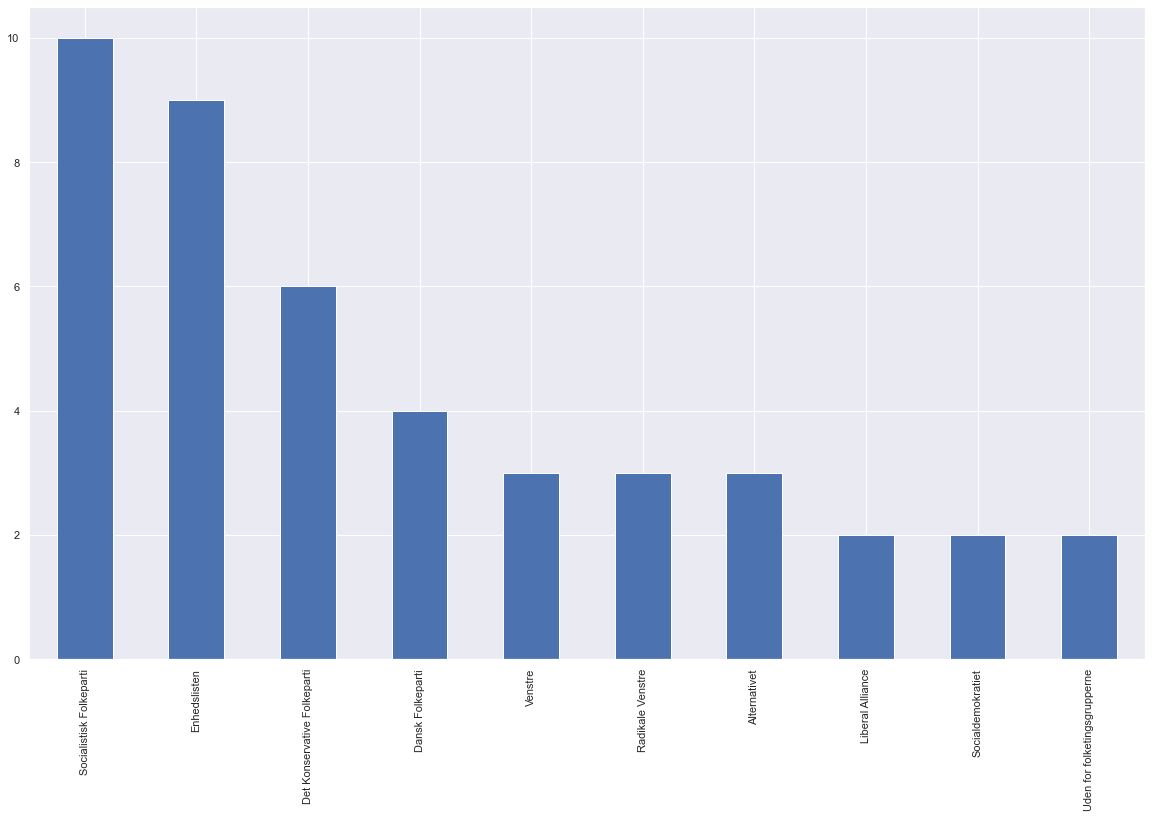

In [61]:
tweets_df_tidy.loc[tweets_df_tidy['tokens'].isin(keywords), 'party'].value_counts().plot.bar()

## ØVELSE 4: Tidy text data (reddit data)

Du skal nu tokenize alle *kommentarerne* i reddit datasættet (kolonnen `comment_body`)

1. Brug `.apply()` til at anvende tokenizer funktion på hele reddit datasættet til at lave en tokens kolonne (det kan være en god ide at teste funktionen med en enkelt kommentar først)
2. Brug `.explode()` til at konvertere data til et tidy format
3. Brug `.value_counts()` til at optælle tokens

**Bonus**

- Undersøg, hvor mange gange coronavirus er nævnt (tænkt gerne synonymer med!)